# Analysing a Whatsapp conversation with Python

For this short project I will analyze a Whatsapp conversation to get details on daily messages sent and most common words used by sender.

This works with any exported chat without media. You can export a chat in Whatsapp by clicking on `More -> Export Chat -> Without Media`.

There are very good libraries for working with natural language like `NLTK`, but for this exercise I decided to keep everything as basic as possible and work with pure python with the addition of pandas.

In [1]:
# Importing libraries
import string
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

Reading the `.txt` file and using `.splitlines()` to separate into a list

In [2]:
# Importing the file
chat = open("_chat.txt")
# Reading contents
txt = chat.read()
# Closing chat
chat.close()
# Splitting into lines
txt = txt.splitlines()

In [3]:
# First element is encryption message so we remove it
txt.pop(0)

'[17/12/2019, 17:48:46] Hannah Ker: \u200eMessages to this chat and calls are now secured with end-to-end encryption.'

Length of the conversation:

In [4]:
len(txt)

8974

In [5]:
txt[0]

'[17/12/2019, 17:48:46] Hannah Ker: This is hannah!'

We need to do some data cleaning. Since media is omitted, any sent image/video/audio will show up as `\u200e ... omitted`. Normal messages have the structure `[Timestamp] Sender: Message`, so we will only keep messages that start with an opening bracket. Also, some empty strings are included, so we also remove any element that is blank.

In [6]:
# Cleaning
txt = [a for a in txt if a != '']
txt = [a for a in txt if a[0] == '[']

Since we are working with dates, we will extract elements 2 to 11 for every message, which is the date in format YYYY/MM/DD, and store them in `date`:

In [7]:
# Get dates
date = []
for i in range(len(txt)):
    date.append(txt[i][1:11])

In order to use a Pandas DataFrame, we create a Dictionary with the columns `date` and `text`:

In [8]:
dictionary = {'date': date, 'text': txt}

Use `pd.DataFrame` to create a Dataframe from `dictionary`

In [9]:
txt = pd.DataFrame(dictionary, columns = ['date', 'text'])

See the first few elements:

In [10]:
txt.head(3)

,date,text
0,17/12/2019,"[17/12/2019, 17:48:46] Hannah Ker: This is han..."
1,17/12/2019,"[17/12/2019, 17:49:06] Alvaro Aguirre: Hello H..."
2,17/12/2019,"[17/12/2019, 17:49:09] Alvaro Aguirre: This is..."


We need to do some more cleaning. We will remove the Timestamp from every text message:

In [11]:
for i in range(len(txt)):
    txt['text'][i] = txt['text'][i][23:len(txt['text'][i])]

Change the `date` column to a Pandas Timestamp:

In [12]:
txt['date'] = pd.to_datetime(txt['date'], dayfirst = True)

Create a new `sender` column by splitting the `text` column on the first colon, and subsequently remove this information from `text`:

In [13]:
txt['sender'] = [a.split(': ', 1)[0] for a in txt['text']]
txt['text'] = [a.split(': ', 1)[1] for a in txt['text']]

In [14]:
txt.head(3)

,date,text,sender
0,2019-12-17,This is hannah!,Hannah Ker
1,2019-12-17,Hello Hannah,Alvaro Aguirre
2,2019-12-17,This is Alvaro!,Alvaro Aguirre


Use `.groupby()` to group the data by date and sender:

In [15]:
txt.groupby(['date', 'sender']).count().head()

text
date       sender              
2019-12-17 Alvaro Aguirre    17
           Hannah Ker        14
2019-12-18 Alvaro Aguirre    22
           Hannah Ker        19
2019-12-19 Hannah Ker         2

Mean of daily texts by sender

In [16]:
txt.groupby(['date', 'sender']).count().groupby('sender').text.mean()

sender
Alvaro Aguirre    22.655914
Hannah Ker        21.597884
Name: text, dtype: float64

### Plot of Daily Texts

Now we can plot the total texts by day, and the texts by sender. I have added two vertical lines in March 22nd and June 2nd. In this case, I am plotting the texts between me and my girlfriend. We live in the same student accommodation, but due to Covid-19 she left the UK to go back home between those days. I thought it would be interesting to see if our text patterns would change in this period. Visually, it doesn't seem so.

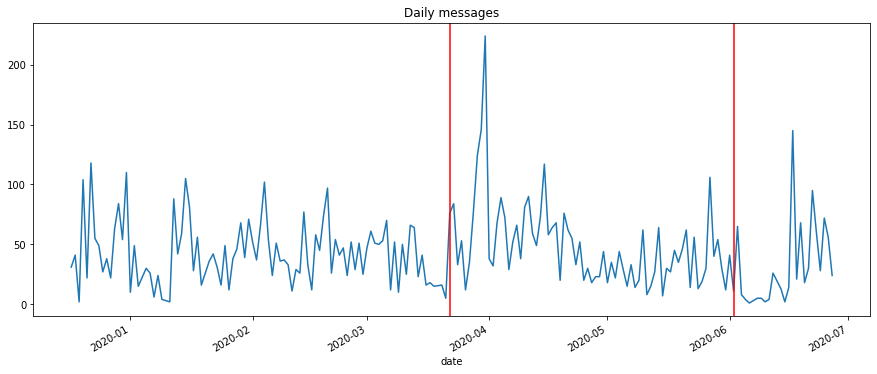

In [17]:
fig, ax = plt.subplots(figsize=(15,6))
txt.groupby(['date']).count()['text'].plot(ax = ax);
plt.title("Daily messages");
plt.axvline(dt.datetime(2020, 3, 22), color = "red");
plt.axvline(dt.datetime(2020, 6, 2), color = "red");

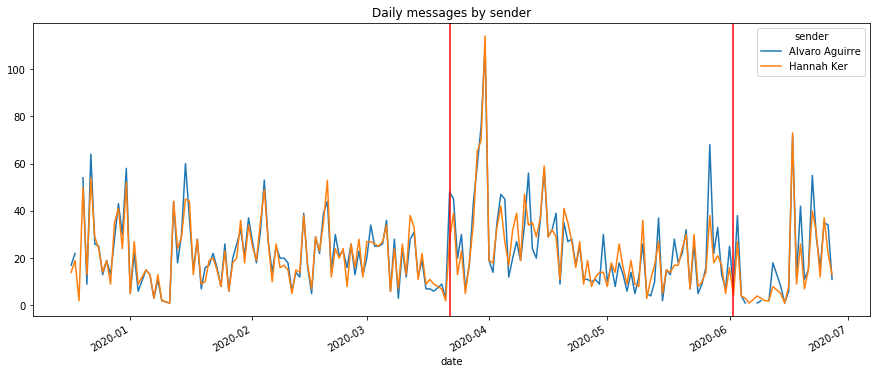

In [18]:
fig, ax = plt.subplots(figsize=(15,6))
txt.groupby(['date', 'sender']).count()['text'].unstack().plot(ax=ax);
plt.title("Daily messages by sender");
plt.axvline(dt.datetime(2020, 3, 22), color = "red");
plt.axvline(dt.datetime(2020, 6, 2), color = "red");

### Most common words

I wanted to see what are the words each sender used the most. To do so, I worked with a dictionary

In [19]:
# Separate senders
senders = txt['sender'].unique()
senders

# Create a function that gets all text from a sender
def text_from_sender(sender):
    return list(txt['text'][txt['sender'] == sender])

# Put in dictionary
messages = {}
for i in range(len(senders)):
    messages[senders[i]] = text_from_sender(senders[i])

Create a list with "stopwords" we don't want to include in our analysis:

In [20]:
stopwords = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now", "i'm", "im", "i’m"]

Create a top function that takes a sender as input and a number i, and returns the top i-th words used by that sender:

In [21]:
# Function top
def top(x, i):

    # Get words from sender x, remove punctuation signs, separate into a list, lowercase
    words = list(' '.join(messages[x]).lower().translate(str.maketrans('','', string.punctuation)).split())

    # Use a set to transform into unique
    unique_words = set(list(words))
    
    # Keep non-stopwords
    unique_words = [a for a in unique_words if a not in stopwords]
    
    # Initialize empty dictioanry
    count = {}
    
    # Count instances of every word
    for word in unique_words:
        count[word] = words.count(word)
    
    # Sort to get top words
    top_words = sorted(count.items(), key = lambda x: x[1], reverse = True)
    
    # Return i-th top words
    return top_words[0:i]

In [22]:
top('Alvaro Aguirre', 5)

[('good', 194), ('hey', 158), ('oh', 156), ('well', 133), ('like', 121)]

In [23]:
top('Hannah Ker', 5)

[('good', 196), ('like', 167), ('oh', 134), ('call', 134), ('ok', 124)]

### Length of messages

Finally, let's see the average length of a message, and how this moves over time. We can add a new column to the `txt` Data Frame with the length of each message:

In [24]:
txt['length'] = txt['text'].str.split().apply(len)

In [25]:
txt.head(3)

,date,text,sender,length
0,2019-12-17,This is hannah!,Hannah Ker,3
1,2019-12-17,Hello Hannah,Alvaro Aguirre,2
2,2019-12-17,This is Alvaro!,Alvaro Aguirre,3


Average length of message:

In [26]:
# Total
txt['length'].mean()

6.388500482160077

In [27]:
# Per sender
txt.groupby('sender')['length'].mean()

sender
Alvaro Aguirre    6.337921
Hannah Ker        6.440715
Name: length, dtype: float64

Plot how message length varies every day:

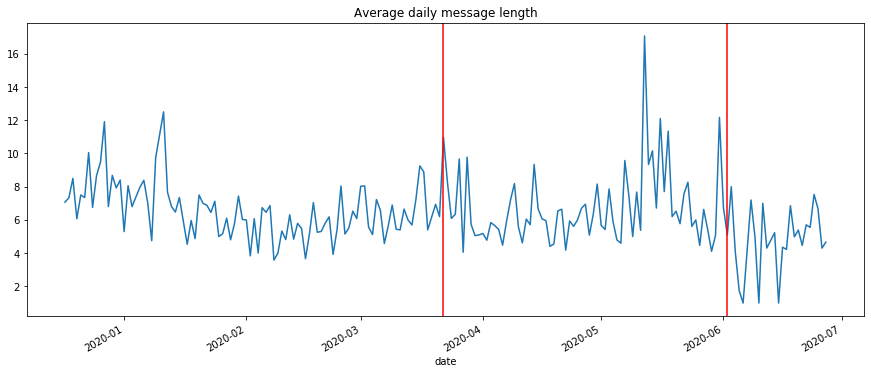

In [28]:
fig, ax = plt.subplots(figsize=(15,6))
txt.groupby('date')['length'].mean().plot(ax = ax);
plt.title("Average daily message length");
plt.axvline(dt.datetime(2020, 3, 22), color = "red");
plt.axvline(dt.datetime(2020, 6, 2), color = "red");

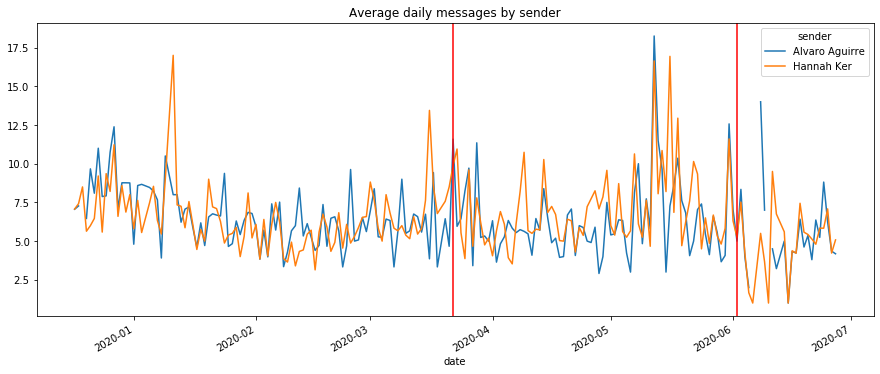

In [29]:
fig, ax = plt.subplots(figsize=(15,6))
txt.groupby(['date', 'sender'])['length'].mean().unstack().plot(ax = ax);
plt.title("Average daily messages by sender");
plt.axvline(dt.datetime(2020, 3, 22), color = "red");
plt.axvline(dt.datetime(2020, 6, 2), color = "red");